## Import packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import math, csv

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Hyper parameter setting

In [2]:
token = 'words' # based on words or chars
embed_size = 300 # how big is each word vector
max_features = 20890 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 40 # max number of words in a comment to use

## File path

In [3]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
QUESTION_PATH = './question.csv'
embed_files = {'words': './word_embed.txt', 'chars': './char_embed.txt'}

## Some helper function

In [4]:
# Get question id from a list. Remove the Q
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

# Get the text
def get_texts(q_list, question_path=QUESTION_PATH):
    qes = pd.read_csv(question_path)
    ids = get_ids(q_list)
    all_tokens = qes[token]
    texts = [all_tokens[t] for t in ids]
    return texts

## Tokenize

In [5]:
stopwords = dict()

In [6]:
tokenizer = Tokenizer(num_words=max_features, lower=False) # Don't lower the W or L!!!
tokenizer.fit_on_texts(pd.read_csv(QUESTION_PATH)['words'])

num_doc = tokenizer.document_count # int: total document number
word_docs = tokenizer.word_docs # dict: document number of each token

# dict: inverse document frequency
idf = dict()
for t, n in word_docs.items():
    idf[t] = math.log(num_doc/n)
    
idf_list = sorted(idf.items(), key=lambda e:e[1])
print (idf_list[:20])
stopwords['words'] = [i[0] for i in idf_list[:5]]

[('W17378', 1.1738599275889938), ('W19355', 1.5684105652363736), ('W16319', 1.597352179677643), ('W18238', 1.7394524499517106), ('W18103', 1.8650951592201621), ('W05733', 2.0606361320708224), ('W17057', 2.084997646885859), ('W07863', 2.1986767011331696), ('W01490', 2.2740809053005457), ('W05284', 2.323375539646871), ('W04476', 2.40264413011684), ('W18804', 2.597636086871165), ('W03472', 2.659887023506065), ('W10157', 2.759316906501473), ('W18399', 2.840443977759901), ('W08238', 2.9810795974015925), ('W12244', 3.0159902313694933), ('W11385', 3.0463705864256148), ('W00863', 3.0556559736279603), ('W19606', 3.057640274958966)]


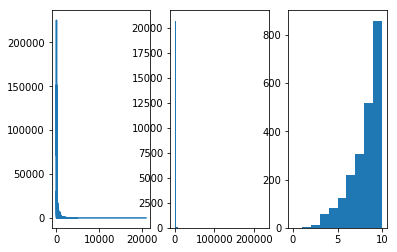

In [7]:
# visualize
doc_list = [n for w,n in word_docs.items()]
idf_log = [n for w,n in idf_list]
plt.subplot(131)
plt.plot(doc_list)
plt.subplot(132)
n,bins,patch = plt.hist(doc_list, bins = 70)
plt.subplot(133)
n,bins,patch = plt.hist(idf_log, range = (0,10))
plt.show()

In [8]:
tokenizer = Tokenizer(num_words=max_features, lower=False) # Don't lower the W or L!!!
tokenizer.fit_on_texts(pd.read_csv(QUESTION_PATH)['chars'])

num_doc = tokenizer.document_count # int: total document number
word_docs = tokenizer.word_docs # dict: document number of each token

# dict: inverse document frequency
idf = dict()
for t, n in word_docs.items():
    idf[t] = math.log(num_doc/n)
    
idf_list = sorted(idf.items(), key=lambda e:e[1])
print (idf_list[:30])
stopwords['chars'] = [i[0] for i in idf_list[:5]]

[('L0104', 0.9891870277799357), ('L2214', 1.094979551154157), ('L1861', 1.230000459222459), ('L2582', 1.4118449418617784), ('L3019', 1.4432489724434485), ('L0143', 1.490857739112166), ('L2218', 1.5302196585010468), ('L1132', 1.5501576186150134), ('L1128', 1.719324008235376), ('L0362', 1.8650951592201621), ('L1187', 1.9857186015439008), ('L1368', 1.9913142279010605), ('L1796', 2.0113749283576863), ('L0260', 2.084997646885859), ('L0578', 2.1293465071342474), ('L2568', 2.1728798507791067), ('L2927', 2.197539002376929), ('L0507', 2.232463486110437), ('L0050', 2.2418632479975256), ('L2237', 2.2944608917273306), ('L1346', 2.322212838407117), ('L1900', 2.34704721416398), ('L0942', 2.3621590306114486), ('L0156', 2.3637485199035257), ('L2272', 2.3764823067991725), ('L0762', 2.380822572102415), ('L1742', 2.446897285420478), ('L2600', 2.4660635180563046), ('L2172', 2.4924194107329414), ('L0423', 2.5216056559052626)]


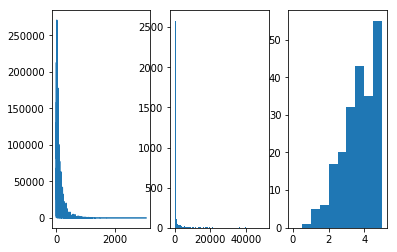

In [9]:
# visualize
doc_list = [n for w,n in word_docs.items()]
idf_log = [n for w,n in idf_list]
plt.subplot(131)
plt.plot(doc_list)
plt.subplot(132)
n,bins,patch = plt.hist(doc_list, range=(0,50000), bins = 70)
plt.subplot(133)
n,bins,patch = plt.hist(idf_log, range = (0,5))
plt.show()

20890


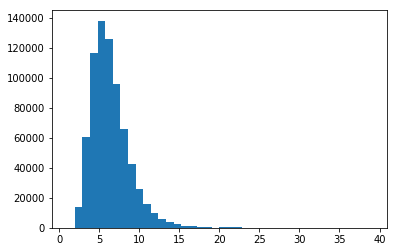

In [10]:
questions = pd.read_csv(QUESTION_PATH)
len_questions = []
all_chars = []
for line in questions[token]:
    question = line.split()
    len_questions.append(len(question))
    all_chars.extend(question)
all_chars = set(all_chars)
print (len(all_chars))

n,bins,patch = plt.hist(len_questions, bins=40)
plt.show()

In [11]:
questions = pd.read_csv(QUESTION_PATH)
col1 = questions['qid']
w = questions['words']
l = questions['chars']

file = open('q_no_stopwords.csv', 'w', newline='')
writer=csv.writer(file, delimiter=",")
header=['qid','words','chars']

# remove stopwords in words
col2=[]
for line in w:
    text = ''
    ws = text_to_word_sequence(line, lower=False)
    for word in ws:
        if word not in stopwords['words']:
            text += word+' '
    col2.append(text)
    
# remove stopwords in chars
col3=[]
for line in l:
    text = ''
    ws = text_to_word_sequence(line, lower=False)
    for word in ws:
        if word not in stopwords['chars']:
            text += word+' '
    col3.append(text)
    
writer.writerow(header)
writer.writerows(zip(col1, col2, col3))
file.close()            

20885


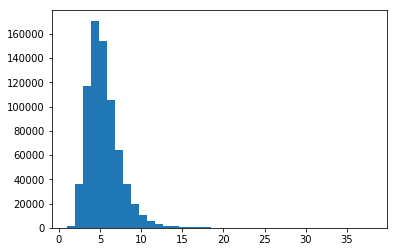

In [12]:
questions = pd.read_csv('q_no_stopwords.csv')
len_questions = []
all_chars = []
l=0
for line in questions['words']:
    l += 1
    #print (l)
    question = line.split()
    len_questions.append(len(question))
    all_chars.extend(question)
all_chars = set(all_chars)
print (len(all_chars))

n,bins,patch = plt.hist(len_questions, bins=38)
plt.show()

3043


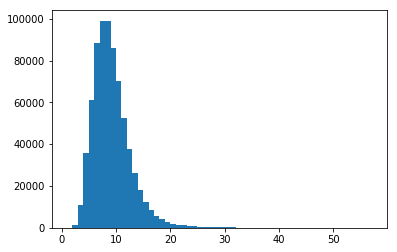

In [13]:
questions = pd.read_csv('q_no_stopwords.csv')
len_questions = []
all_chars = []
l=0
for line in questions['chars']:
    l += 1
    #print (l)
    question = line.split()
    len_questions.append(len(question))
    all_chars.extend(question)
all_chars = set(all_chars)
print (len(all_chars))

n,bins,patch = plt.hist(len_questions, bins=56)
plt.show()

### After removing stop words and chars

20890-5个词语。每个问题最短1个，最长38个，大部分小于15个。

3048-5个单字。每个问题最短1个，最长56个，大部分小于20个。